# Bike Share Trips Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1= pd.read_csv('trip.csv', error_bad_lines=False)
df2= pd.read_csv('station.csv', error_bad_lines=False)

In [3]:
df1.head(2)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0


In [4]:
df2.head(2)

,station_id,name,lat,long,install_date,install_dockcount,modification_date,current_dockcount,decommission_date
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18,NaN,18,NaN
1,BT-03,2nd Ave & Vine St,47.615829,-122.348564,10/13/2014,16,NaN,16,NaN


<h3> Data Description </h3> <br><br> Above given is the cycle share dataset which shows bicycle trip details from Seattle's City Share System. <br><br> The Pronto Cycle Share system consists of 500 bikes and 54 stations located in Seattle. Pronto provides open data on individual trips and stations. This dataset can be found on Kaggle. <br><br> <b>Station dataset</b><br>

station_id: station ID number<br>
name: name of station<br>
lat: station latitude<br>
long: station longitude<br>
install_date: date that station was placed in service<br>
install_dockcount: number of docks at each station on the installation date<br>
modification_date: date that station was modified, resulting in a change in location or dock count<br>
current_dockcount: number of docks at each station on 8/31/2016<br>
decommission_date: date that station was placed out of service<br><br>
<b>Trip dataset</b><br>

trip_id: numeric ID of bike trip taken<br>
starttime: day and time trip started, in PST<br>
stoptime: day and time trip ended, in PST<br>
bikeid: ID attached to each bike<br>
tripduration: time of trip in seconds<br>
from_station_name: name of station where trip originated<br>
to_station_name: name of station where trip terminated<br>
from_station_id: ID of station where trip originated<br>
to_station_id: ID of station where trip terminated<br>
usertype: "Short-Term Pass Holder" is a rider who purchased a 24-Hour or 3-Day Pass; "Member" is a rider who purchased a Monthly or an Annual Membership<br>
gender: gender of rider<br>
birthyear: birth year of rider <br>

Now, we merge df1 and df2 to get a wholistic view of trips and docking stations.

<h2> Data Cleaning and Prepping </h2> 

Few trips seemed to be entered twice so first of all, we remove the rows from trip dataset which are duplicated. 

In [5]:
df1.drop_duplicates(inplace=True)

Next, we merge the trips and stations datasets. 

In [6]:
data = df2.merge(df1, left_on='station_id', right_on='from_station_id')

In [7]:
data.head(2)

,station_id,name,lat,long,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,...,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18,NaN,18,NaN,680,...,10/13/2014 15:57,SEA00267,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,BT-01,CH-03,Member,Male,1977.0
1,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18,NaN,18,NaN,692,...,10/13/2014 16:10,SEA00080,759.511,3rd Ave & Broad St,Westlake Ave & 6th Ave,BT-01,SLU-15,Short-Term Pass Holder,NaN,NaN


In [8]:
data.columns

Index([u'station_id', u'name', u'lat', u'long', u'install_date',
       u'install_dockcount', u'modification_date', u'current_dockcount',
       u'decommission_date', u'trip_id', u'starttime', u'stoptime', u'bikeid',
       u'tripduration', u'from_station_name', u'to_station_name',
       u'from_station_id', u'to_station_id', u'usertype', u'gender',
       u'birthyear'],
      dtype='object')

In [9]:
len(data)

236060

Next, we drop few unnecessary columns which either duplicate data or are of no use for our analysis. 

In [10]:
data.drop(['station_id', 'lat', 'long', 'from_station_id','to_station_id', 'bikeid'], inplace=True, axis=1)

In [11]:
data.head(2)

,name,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,starttime,stoptime,tripduration,from_station_name,to_station_name,usertype,gender,birthyear
0,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,680,10/13/2014 15:39,10/13/2014 15:57,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1977.0
1,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,692,10/13/2014 15:57,10/13/2014 16:10,759.511,3rd Ave & Broad St,Westlake Ave & 6th Ave,Short-Term Pass Holder,NaN,NaN


Here, in the above given dataset, each row represents a unique trip taken by a person using this bike share system. Morover, 

We add a few columns. First of all, we add a boolean column called docks_added which is true if current dockcount is more than installed dockcount. 

In [12]:
data['docks_added']= data.install_dockcount< data.current_dockcount

In [13]:
data.head(2)

,name,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,starttime,stoptime,tripduration,from_station_name,to_station_name,usertype,gender,birthyear,docks_added
0,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,680,10/13/2014 15:39,10/13/2014 15:57,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1977.0,False
1,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,692,10/13/2014 15:57,10/13/2014 16:10,759.511,3rd Ave & Broad St,Westlake Ave & 6th Ave,Short-Term Pass Holder,NaN,NaN,False


<h2> Insights</h2> 

<h2> Insight 1 </h2> <br>

 <h3> Brief Summary </h3> <br>In members usertype, Older people (born before 1948) highly tend to roam on the most popular path if their trip duration is more than 1690 secs but this isn't true for younger people (born after 1948)

<h3> Charts and Graphs </h3> <br>

In [14]:
newDF=data.copy()

First, we find the most popular path or route, that is the path with highest number of trips. 

In [15]:
data.groupby(['from_station_name', 'to_station_name'], as_index=False)['trip_id'].count().sort_values(by='trip_id',ascending=False).head(5).rename(columns={'trip_id': 'trip_count'})

,from_station_name,to_station_name,trip_count
2184,Pier 69 / Alaskan Way & Clay St,Pier 69 / Alaskan Way & Clay St,4209
2188,Pier 69 / Alaskan Way & Clay St,Seattle Aquarium / Alaskan Way S & Elliott Bay...,2291
2405,Seattle Aquarium / Alaskan Way S & Elliott Bay...,Pier 69 / Alaskan Way & Clay St,1605
2409,Seattle Aquarium / Alaskan Way S & Elliott Bay...,Seattle Aquarium / Alaskan Way S & Elliott Bay...,1150
593,3rd Ave & Broad St,2nd Ave & Pine St,1101


To validate the above numbers, we check as follows: 

In [16]:
len(data[(data.from_station_name=='Pier 69 / Alaskan Way & Clay St') & (data.to_station_name=='Pier 69 / Alaskan Way & Clay St')])

4209

We create a new column which represents whether the trip is on most popular route or not.

In [17]:
newDF['popular_route'] = (newDF.from_station_name=='Pier 69 / Alaskan Way & Clay St') & (newDF.to_station_name=='Pier 69 / Alaskan Way & Clay St')

In [18]:
newDF.head(2)

,name,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,starttime,stoptime,tripduration,from_station_name,to_station_name,usertype,gender,birthyear,docks_added,popular_route
0,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,680,10/13/2014 15:39,10/13/2014 15:57,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1977.0,False,False
1,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,692,10/13/2014 15:57,10/13/2014 16:10,759.511,3rd Ave & Broad St,Westlake Ave & 6th Ave,Short-Term Pass Holder,NaN,NaN,False,False


Through analysis, we figured out that gender and birthyear details are available only for members and hence there are lots of null values which prevented making the decision tree. So we calculated the below metrics only for member usertype by removing rows that had trips of non-members.

In [19]:
newDF = newDF[(newDF.gender.notnull()) & (newDF.birthyear.notnull())]

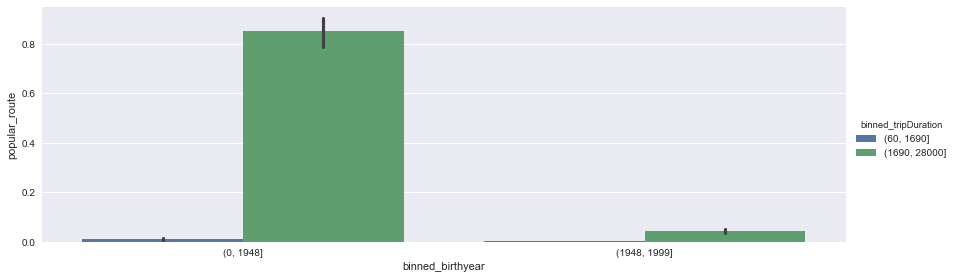

In [20]:
newDF['binned_birthyear']=pd.cut(newDF.birthyear, [0, 1948, 1999])
newDF['binned_tripDuration']=pd.cut(newDF.tripduration, [60, 1690, 28000])
sns.factorplot(x='binned_birthyear', y='popular_route',hue='binned_tripDuration', data=newDF , kind='bar',aspect=3)

## The above graph shows that for trips with duration greater than 1690 secs, older people (born before 1948) tend to visit the popular route much more than younger people (born after 1948).

<h3> Machine Learning Mastery </h3> <br>

We used the decision tree to come up with this finding. 

Need to remove all parameters related to station as they directly co-relate.

In [21]:
newDFGraph=data.copy()

In [22]:
newDFGraph = newDFGraph[(newDFGraph.gender.notnull()) & (newDFGraph.birthyear.notnull())]

In [23]:
newDFGraph['popular_route'] = (newDFGraph.from_station_name=='Pier 69 / Alaskan Way & Clay St') & (newDFGraph.to_station_name=='Pier 69 / Alaskan Way & Clay St')

In [24]:
newDFGraph.drop(['name','install_date','modification_date', 'decommission_date','from_station_name','to_station_name', 'trip_id','starttime','stoptime','install_dockcount','current_dockcount'], axis=1, inplace=True)

In [25]:
newDFGraph.head(2)

,tripduration,usertype,gender,birthyear,docks_added,popular_route
0,1126.426,Member,Male,1977.0,False,False
5,884.403,Member,Male,1979.0,False,False


In [26]:
newDFGraph = pd.get_dummies(newDFGraph, columns=['usertype','gender'],dummy_na=True, sparse=True)

In [27]:
X=newDFGraph.drop('popular_route', axis=1)

In [28]:
Y=newDFGraph.popular_route

In [29]:
dt = tree.DecisionTreeClassifier(max_depth=2)

In [30]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

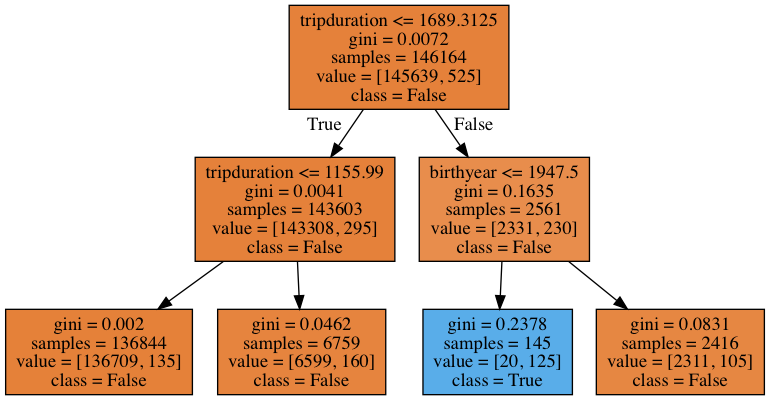

In [31]:
#Below given is the code to visualize the decision tree
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

<h3> Managerial Insight <h3>

Here, we can say that more cycles comfortable for older people should be kept available on most popular route as they tend to roam the most. This can also be a helping factor for type of advertisements that should be posted on popular routes. 

<h2> Insight 2 </h2> <br>

<h3> Brief Summary </h3> <br> The probablity of modification of stations is very high when the dock counts are less than 12 or greater than 24 unless the station is Harrison and Broadway

<h3> Charts and Graphs </h3> <br>

In [32]:
dfGraph2 = data.copy()

If modification date is not present, it means that dock has not been modified.

In [33]:
dfGraph2['Modify'] = dfGraph2.modification_date.notnull()

In [34]:
dfGraph2['Harrison & Broadway'] = dfGraph2.from_station_name=='E Harrison St & Broadway Ave E'

In [35]:
dfGraph2.head(2)

,name,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,starttime,stoptime,tripduration,from_station_name,to_station_name,usertype,gender,birthyear,docks_added,Modify,Harrison & Broadway
0,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,680,10/13/2014 15:39,10/13/2014 15:57,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1977.0,False,False,False
1,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,692,10/13/2014 15:57,10/13/2014 16:10,759.511,3rd Ave & Broad St,Westlake Ave & 6th Ave,Short-Term Pass Holder,NaN,NaN,False,False,False


In [36]:
dfGraph2['Installed_Dock_Cut'] = pd.cut(dfGraph2.install_dockcount, [0,12,24,30])

In [37]:
dfGraph2.groupby(['Installed_Dock_Cut','Harrison & Broadway'])['Modify'].mean()

Installed_Dock_Cut  Harrison & Broadway
(0, 12]             False                  1.000000
(12, 24]            False                  0.134968
                    True                   1.000000
(24, 30]            False                  1.000000
Name: Modify, dtype: float64

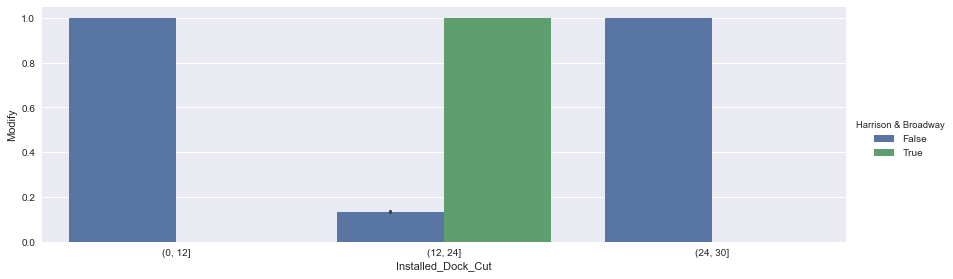

In [38]:
sns.factorplot(x='Installed_Dock_Cut',y='Modify',hue='Harrison & Broadway',data=dfGraph2, kind='bar',
              aspect =3)

The above given graph means that the probablity of modification of stations is very high when the dock counts are less than 12 or greater than 24 unless the station is Harrison and Broadway. 

<h3> Machine Learning Mastery </h3> <br>

In [39]:
dfML = data.copy()

In [40]:
dfML['Modified'] = dfML.modification_date.notnull()

In [41]:
dfML.Modified.value_counts()

False    171394
True      64666
Name: Modified, dtype: int64

In [42]:
dfML.columns

Index([u'name', u'install_date', u'install_dockcount', u'modification_date',
       u'current_dockcount', u'decommission_date', u'trip_id', u'starttime',
       u'stoptime', u'tripduration', u'from_station_name', u'to_station_name',
       u'usertype', u'gender', u'birthyear', u'docks_added', u'Modified'],
      dtype='object')

In [43]:
dfML.drop(['modification_date','current_dockcount','trip_id','name','starttime','stoptime','install_date','decommission_date','docks_added'], axis=1, inplace=True)

In [44]:
dfML = pd.get_dummies(dfML, columns=['from_station_name', 'to_station_name', 'usertype', 'gender'],dummy_na=True )

In [45]:
dfML.fillna(dfML.mean(), inplace=True)

,install_dockcount,tripduration,birthyear,Modified,from_station_name_12th Ave & E Denny Way,from_station_name_12th Ave & E Mercer St,from_station_name_12th Ave & E Yesler Way,from_station_name_12th Ave & NE Campus Pkwy,from_station_name_15th Ave E & E Thomas St,from_station_name_15th Ave NE & NE 40th St,...,to_station_name_Union St & 4th Ave,to_station_name_Westlake Ave & 6th Ave,to_station_name_nan,usertype_Member,usertype_Short-Term Pass Holder,usertype_nan,gender_Female,gender_Male,gender_Other,gender_nan
0,18,1126.426,1977.000000,False,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,18,759.511,1979.879505,False,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,18,770.199,1979.879505,False,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,18,916.706,1979.879505,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,18,914.192,1979.879505,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,18,884.403,1979.000000,False,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6,18,1630.646,1979.879505,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,18,1577.461,1979.879505,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,18,1514.813,1979.879505,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,18,1238.784,1979.879505,False,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [46]:
X = dfML.drop('Modified', axis=1)

In [47]:
Y = dfML.Modified

In [48]:
dt = tree.DecisionTreeClassifier(max_depth=3)

In [49]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

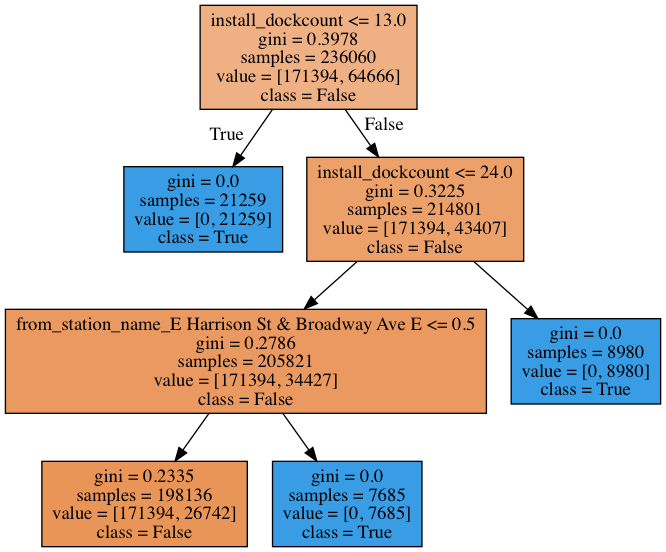

In [50]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## The above graph signifies that for trips starting from Harrison and Broadway station, the modification probablity is not affected by the dock count.

<h3> Managerial Insight <h3>

While taking decisions to modify or add a new station the management should see that the dock count does not decrease from 12 or increase from 24 to improve the probablity of not modifying the station.

<h2> Insight 3 </h2> <br>

<h3> Brief Summary </h3> <br> Female members tend to have longer trip duration than Male members, which contradicts the general norms that female ride less than males. 

<h3> Charts and Graphs </h3> <br>

In [51]:
dfC = data.copy()

In [52]:
dfC2=dfC[(dfC.gender=='Male') | (dfC.gender=='Female')]

In [53]:
dfC2.head(2)

,name,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,starttime,stoptime,tripduration,from_station_name,to_station_name,usertype,gender,birthyear,docks_added
0,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,680,10/13/2014 15:39,10/13/2014 15:57,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1977.0,False
5,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,790,10/13/2014 17:36,10/13/2014 17:51,884.403,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1979.0,False


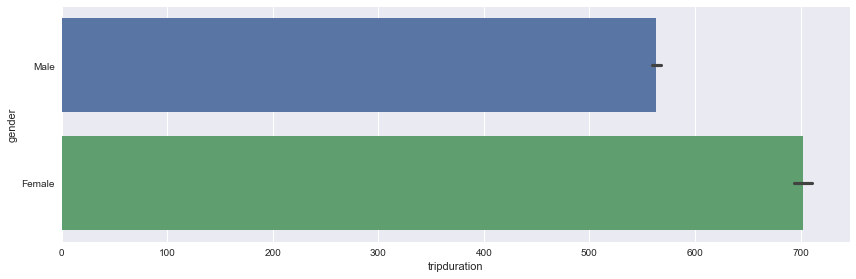

In [54]:
sns.factorplot(x='tripduration',y='gender',data=dfC2, kind='bar',
              aspect =3)

<h3> Machine Learning Mastery </h3> <br>

In [55]:
copied = data.copy()

In [56]:
copied.head(2)

,name,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,trip_id,starttime,stoptime,tripduration,from_station_name,to_station_name,usertype,gender,birthyear,docks_added
0,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,680,10/13/2014 15:39,10/13/2014 15:57,1126.426,3rd Ave & Broad St,Summit Ave E & E Republican St,Member,Male,1977.0,False
1,3rd Ave & Broad St,10/13/2014,18,NaN,18,NaN,692,10/13/2014 15:57,10/13/2014 16:10,759.511,3rd Ave & Broad St,Westlake Ave & 6th Ave,Short-Term Pass Holder,NaN,NaN,False


In [57]:
copied.drop(['trip_id','install_date', 'modification_date','decommission_date','starttime','stoptime'],axis=1, inplace=True)

In [58]:
copied = pd.get_dummies(data=copied, columns=['name','from_station_name','to_station_name','usertype','gender'], dummy_na=True)

In [59]:
copied.fillna(copied.mean(), inplace=True)

,install_dockcount,current_dockcount,tripduration,birthyear,docks_added,name_12th Ave & E Denny Way,name_12th Ave & E Mercer St,name_12th Ave & E Yesler Way,name_12th Ave & NE Campus Pkwy,name_15th Ave E & E Thomas St,...,to_station_name_Union St & 4th Ave,to_station_name_Westlake Ave & 6th Ave,to_station_name_nan,usertype_Member,usertype_Short-Term Pass Holder,usertype_nan,gender_Female,gender_Male,gender_Other,gender_nan
0,18,18,1126.426,1977.000000,False,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,18,18,759.511,1979.879505,False,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,18,18,770.199,1979.879505,False,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,18,18,916.706,1979.879505,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,18,18,914.192,1979.879505,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,18,18,884.403,1979.000000,False,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6,18,18,1630.646,1979.879505,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,18,18,1577.461,1979.879505,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,18,18,1514.813,1979.879505,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,18,18,1238.784,1979.879505,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [60]:
X = copied.drop('tripduration',axis=1)
Y = copied.tripduration

In [61]:
import sklearn.tree
dt = sklearn.tree.DecisionTreeRegressor(max_depth=2)

In [62]:
dt.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

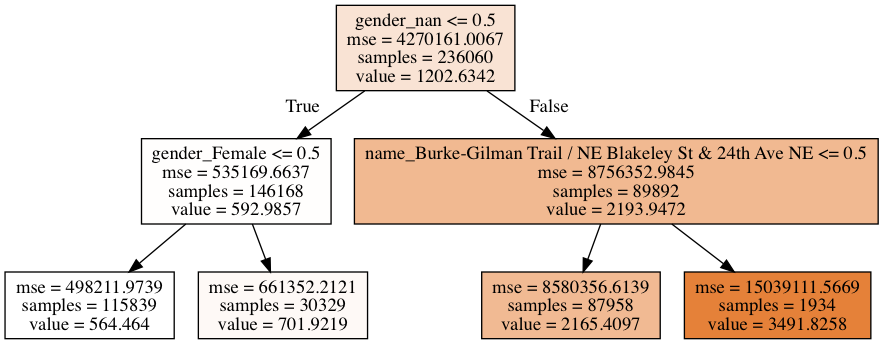

In [63]:
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The above given graph shows for gender nan. Gender nan means that the person is not a member as in this dataset, only members have a gender. 

<h3> Managerial Insight <h3>

Here, we can see an interesting insight as to females ride more than males, and this is true for members only. This means that business can use this data to promote memberships to females as they tend to ride more. 